### Keras and Tensorflow Neural Network (NN)

In [2]:
import pandas as pd
from processing_utils import *
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasRegressor
import random
from pathlib import Path

path = Path('./results/neural_network')

raw_dataset = pd.read_csv('./dataset/data.csv')
dataset = encode_smiles_column_of(
    prune_dataset_lines(
        raw_dataset,
        remove_nan_lines=False,
        remove_nan_cols=True,
        remove_duplicates=True,
        in_favour_of_col='Energy_(kcal/mol)'
    ),
    strategy='count_encoding')

# Tiny Neural Networks with SGD gradient descent

### Cross Validation Score

In [3]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

def cross_validation_of(compiled_neural_network: keras.Model, X: pd.DataFrame, y: pd.DataFrame, epochs=150, batch_size=500, n_splits=5):
    assert y.ndim == 1 or y.shape[1] == 1 
    
    kf = KFold(n_splits=n_splits)
    es = EarlyStopping(monitor='val_loss', patience=20, verbose=0, restore_best_weights=True)
    cross_validation_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.to_numpy()[train_index], X.to_numpy()[test_index]
        y_train, y_test = y.to_numpy()[train_index].reshape(-1, 1), y.to_numpy()[test_index].reshape(-1, 1)

        features_scaler = StandardScaler()
        target_scaler = StandardScaler()

        compiled_neural_network.fit(
            x=features_scaler.fit_transform(X_train), y=target_scaler.fit_transform(y_train), 
            epochs=epochs, batch_size=batch_size, 
            validation_data=(features_scaler.transform(X_test), target_scaler.transform(y_test)), # the model is not trained on this but tested on it.
            callbacks=[es], verbose=0
        )

        cross_validation_scores.append(
            r2_score(
                compiled_neural_network.predict(features_scaler.transform(X_test)), 
                target_scaler.transform(y_test)
            )
        )
    return cross_validation_scores

### Preparing Cross-Validation Data

In [4]:
seed = random.randint(0, 10000)
random_state = np.random.RandomState(seed)
X_train, y_train, X_test, y_test = get_train_data(
    dataset,
    targets_columns=['Energy_(kcal/mol)', 'Energy DG:kcal/mol)'],
    random_state=random_state,
    as_numpy=False,
    validation=False
)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

### Global Neural Network Parameters

In [5]:
EPOCHS = 1000
BATCH_SIZE = 5000
STEPS_PER_EPOCH = X_train.shape[0]//BATCH_SIZE

In [6]:
tiny_model_Energy_ = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_dim=36),
    keras.layers.Dense(1)   
])

tiny_model_Energy_.compile(
    loss='mse', 
    optimizer=SGD(learning_rate=1e-3, momentum=0), 
    metrics=['mse', tfa.metrics.r_square.RSquare()]     
)

tiny_model_EnergyDG = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_dim=36),
    keras.layers.Dense(1)   
])

tiny_model_EnergyDG.compile(
    loss='mse', 
    optimizer=SGD(learning_rate=1e-3, momentum=0), 
    metrics=['mse', tfa.metrics.r_square.RSquare()]     
)

cross_validation_score_Energy_ = cross_validation_of(tiny_model_Energy_, X=X, y=y['Energy_(kcal/mol)'], epochs=EPOCHS, batch_size=BATCH_SIZE)
cross_validation_score_EnergyDG = cross_validation_of(tiny_model_EnergyDG, X=X, y=y['Energy DG:kcal/mol)'], epochs=EPOCHS, batch_size=BATCH_SIZE)

2022-06-22 16:03:54.618520: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 16:03:54.618883: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-06-22 16:03:54.618973: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-06-22 16:03:54.619049: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2022-06-22 16:03:54.619130: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could no

81/81 [==============================] - 0s 422us/step


KeyboardInterrupt: 

In [ ]:
print("tiny_model_Energy_ Cross Validation Score =", np.array(cross_validation_score_Energy_).mean())
print("tiny_model_EnergyDG Cross Validation Score =", np.array(cross_validation_score_EnergyDG).mean())

tiny_model_Energy_ Cross Validation Score = 0.9723016005295948
tiny_model_EnergyDG Cross Validation Score = 0.9714531141558858


## Optimization History Visualisation

In [ ]:
def compute_optimization_history_of(
    compiled_model, X_train: pd.DataFrame, y_train: pd.DataFrame, 
    X_test: pd.DataFrame, y_test: pd.DataFrame, epochs=150, batch_size=500):
    
    es = EarlyStopping(monitor='val_loss', patience=200, verbose=1, restore_best_weights=True)

    features_scaler = StandardScaler()
    target_scaler = StandardScaler()
    
    history = compiled_model.fit(
        features_scaler.fit_transform(X_train), target_scaler.fit_transform(y_train.to_numpy().reshape(-1, 1)), 
        epochs=epochs, batch_size=batch_size, 
        validation_data=(features_scaler.transform(X_test), target_scaler.transform(y_test.to_numpy().reshape(-1, 1))),
        callbacks=[es], verbose=0)

    return history

In [ ]:
import tensorflow_docs as tfdocs
import matplotlib.pyplot as plt
import tensorflow_docs.plots

tiny_model_Energy_.reset_states()
tiny_model_EnergyDG.reset_states()

sgd_histories = {}
sgd_histories['tiny_model_Energy_'] = compute_optimization_history_of(tiny_model_Energy_, X_train, y_train['Energy_(kcal/mol)'], X_test, y_test['Energy_(kcal/mol)'], epochs=EPOCHS, batch_size=BATCH_SIZE)
sgd_histories['tiny_model_EnergyDG'] = compute_optimization_history_of(tiny_model_EnergyDG, X_train, y_train['Energy DG:kcal/mol)'], X_test, y_test['Energy DG:kcal/mol)'], epochs=EPOCHS, batch_size=BATCH_SIZE)

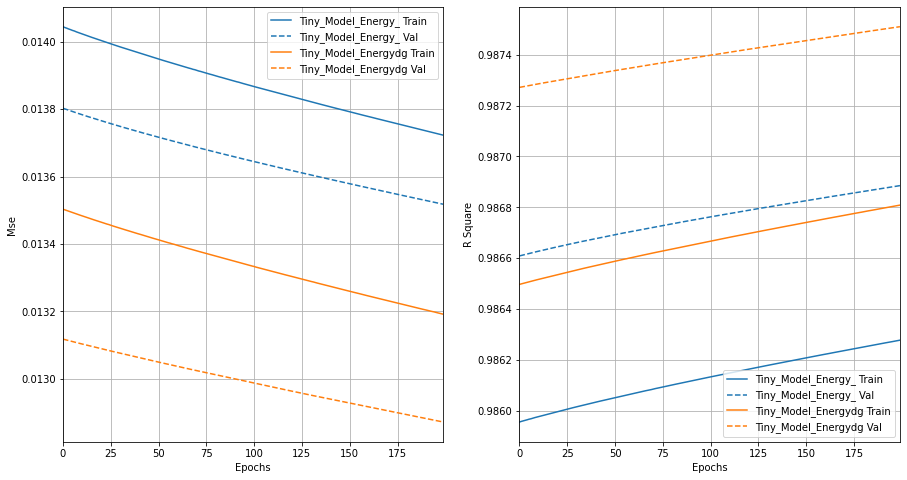

In [ ]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.yscale("linear")
plotter = tfdocs.plots.HistoryPlotter(metric='mse')
plotter.plot(sgd_histories)

plt.subplot(1, 2, 2)
plt.yscale("linear")
plotter = tfdocs.plots.HistoryPlotter(metric='r_square')
plotter.plot(sgd_histories)
plt.savefig(path/'sgd_histories')

# Tiny Neural Networks with Adam Optimizer

In [ ]:
from keras.optimizers import Adam

seed = random.randint(0, 10000)
random_state = np.random.RandomState(seed)
X_train, y_train, X_test, y_test = get_train_data(
    dataset,
    targets_columns=['Energy_(kcal/mol)', 'Energy DG:kcal/mol)'],
    random_state=random_state,
    as_numpy=False,
    validation=False
)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.001, decay_steps=STEPS_PER_EPOCH*100, decay_rate=0.96, staircase=False)

tiny_model_Energy_Adam = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_dim=36),
    keras.layers.Dense(1, activation='linear')
])

tiny_model_Energy_Adam.compile(
    loss='mse', 
    optimizer=Adam(lr_schedule), 
    metrics=['mse', tfa.metrics.r_square.RSquare()]     
)

tiny_model_EnergyDG_Adam = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_dim=36),
    keras.layers.Dense(1, activation='linear')   
])

tiny_model_EnergyDG_Adam.compile(
    loss='mse', 
    optimizer=Adam(lr_schedule), 
    metrics=['mse', tfa.metrics.r_square.RSquare()]     
)

## Optimization History

In [ ]:
X_train, y_train, X_test, y_test = get_train_data(
    dataset,
    targets_columns=['Energy_(kcal/mol)', 'Energy DG:kcal/mol)'],
    random_state=random_state,
    as_numpy=False,
    validation=False
)

adam_histories = {}
adam_histories['tiny_model_Energy_'] = compute_optimization_history_of(tiny_model_Energy_Adam, X_train, y_train['Energy_(kcal/mol)'], X_test, y_test['Energy_(kcal/mol)'], epochs=EPOCHS, batch_size=BATCH_SIZE)
adam_histories['tiny_model_EnergyDG'] = compute_optimization_history_of(tiny_model_EnergyDG_Adam, X_train, y_train['Energy DG:kcal/mol)'], X_test, y_test['Energy DG:kcal/mol)'], epochs=EPOCHS, batch_size=BATCH_SIZE)

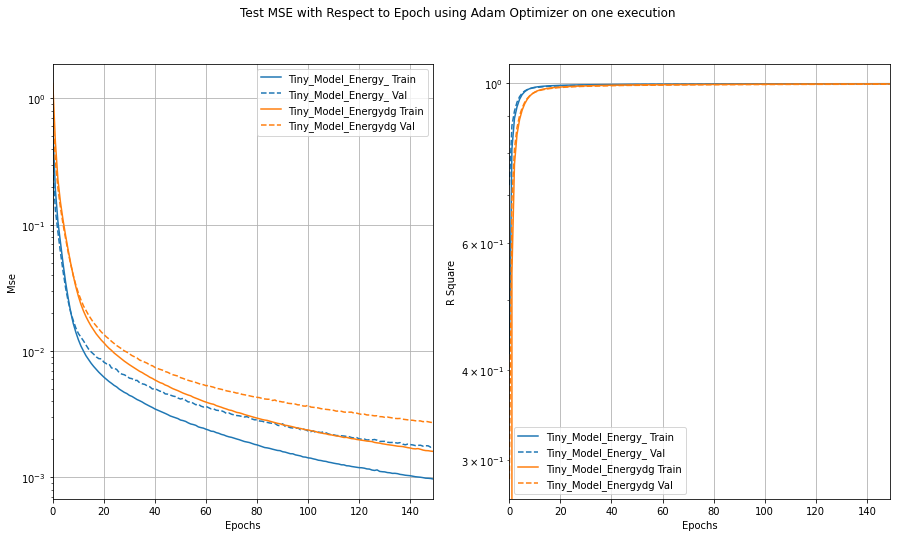

In [ ]:
plt.figure(figsize=(15, 8))
plt.suptitle("Test MSE with Respect to Epoch using Adam Optimizer on one execution")
plt.subplot(1, 2, 1)
plt.yscale("log")
plotter = tfdocs.plots.HistoryPlotter(metric='mse')
plotter.plot(adam_histories)

plt.subplot(1, 2, 2)
plt.yscale("log")
plotter = tfdocs.plots.HistoryPlotter(metric='r_square')
plotter.plot(adam_histories)
plt.savefig(path/'adam_histories_tiny')

## Cross Validation Score

In [ ]:
tiny_model_Energy_Adam.reset_states()
tiny_model_EnergyDG_Adam.reset_states()
cross_validation_score_Energy_Adam = cross_validation_of(tiny_model_Energy_Adam, X=X, y=y['Energy_(kcal/mol)'], epochs=EPOCHS, batch_size=BATCH_SIZE)
cross_validation_score_EnergyDG_Adam = cross_validation_of(tiny_model_EnergyDG_Adam, X=X, y=y['Energy DG:kcal/mol)'], epochs=EPOCHS, batch_size=BATCH_SIZE)

81/81 [==============================] - 0s 677us/step


In [ ]:
print("tiny_model_Energy_ Cross Validation Score with Adam =", np.array(cross_validation_score_Energy_Adam).mean())
print("tiny_model_EnergyDG Cross Validation Score with Adam =", np.array(cross_validation_score_EnergyDG_Adam).mean())

tiny_model_Energy_ Cross Validation Score with Adam = 0.9994505079396259
tiny_model_EnergyDG Cross Validation Score with Adam = 0.9990754003359342


# Fat Neural Network with Adam Optimizer 

In [ ]:
fat_model_Energy_ = keras.Sequential([
    keras.layers.Dense(512, activation='relu', input_dim=36),
    keras.layers.Dense(512, activation='relu', input_dim=512),
    keras.layers.Dense(512, activation='relu', input_dim=512),
    keras.layers.Dense(512, activation='relu', input_dim=512),
    keras.layers.Dense(1, activation='linear')
])

fat_model_EnergyDG = keras.Sequential([
    keras.layers.Dense(512, activation='relu', input_dim=36),
    keras.layers.Dense(512, activation='relu', input_dim=512),
    keras.layers.Dense(512, activation='relu', input_dim=512),
    keras.layers.Dense(512, activation='relu', input_dim=512),
    keras.layers.Dense(1, activation='linear')
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.001, decay_steps=STEPS_PER_EPOCH*100, decay_rate=0.96, staircase=False)

fat_model_Energy_.compile(
    loss='mse', 
    optimizer=Adam(lr_schedule), 
    metrics=['mse', tfa.metrics.r_square.RSquare()]     
) 

fat_model_EnergyDG.compile(
    loss='mse', 
    optimizer=Adam(lr_schedule), 
    metrics=['mse', tfa.metrics.r_square.RSquare()]
) 

## Optimization History

In [ ]:
fat_model_Energy_.reset_states()    # cell takes 1m22 on my machine
fat_model_EnergyDG.reset_states()
adam_histories = {}
adam_histories['fat_model_Energy_'] = compute_optimization_history_of(fat_model_Energy_, X_train, y_train['Energy_(kcal/mol)'], X_test, y_test['Energy_(kcal/mol)'], batch_size=BATCH_SIZE, epochs=EPOCHS)
adam_histories['fat_model_EnergyDG'] = compute_optimization_history_of(fat_model_EnergyDG, X_train, y_train['Energy DG:kcal/mol)'], X_test, y_test['Energy DG:kcal/mol)'], epochs=EPOCHS, batch_size=BATCH_SIZE)

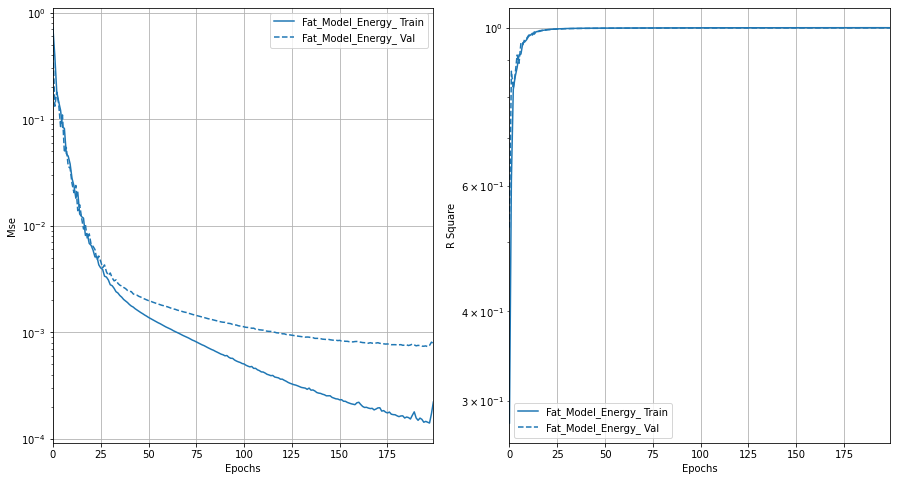

In [ ]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.yscale("log")
plotter = tfdocs.plots.HistoryPlotter(metric='mse')
plotter.plot(adam_histories)

plt.subplot(1, 2, 2)
plt.yscale("log")
plotter = tfdocs.plots.HistoryPlotter(metric='r_square')
plotter.plot(adam_histories)
plt.savefig(path/'adam_histories_fat')

## Cross-Validation Score

In [ ]:
fat_model_Energy_.reset_states()
fat_model_EnergyDG.reset_states()
cross_validation_score_Energy_ = cross_validation_of(fat_model_Energy_, X=X, y=y['Energy_(kcal/mol)'], epochs=EPOCHS, batch_size=BATCH_SIZE)
cross_validation_score_EnergyDG = cross_validation_of(fat_model_EnergyDG, X=X, y=y['Energy DG:kcal/mol)'], epochs=EPOCHS, batch_size=BATCH_SIZE)

81/81 [==============================] - 0s 2ms/step


KeyboardInterrupt: 

In [ ]:
print("tiny_model_Energy_ Cross Validation Score with Adam =", np.array(cross_validation_score_Energy_).mean())
print("tiny_model_EnergyDG Cross Validation Score with Adam =", np.array(cross_validation_score_EnergyDG).mean())